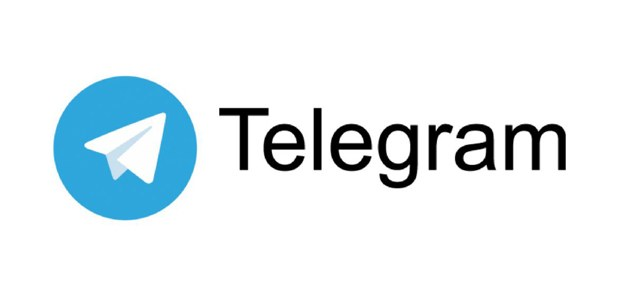

# **PROJETO PIPELINE DE DADOS DO TELEGRAM** 

**Projeto criado a partir do curso Profissão: Analista de Dados da EBAC - Escola Britânica de Artes Criativa & Tecnologia.**

## **Tópicos**

1. Contexto;
1. Criação do Bot;
1. Bot API;
1. Dados;
1. Ingestão;
1. ETL;
1. Apresentação;
1. Conclusão.

## **1. Contexto:**

**O que é Chatbot?**

Um chatbot é um programa de computador ou um tipo de inteligência artificial (IA) projetado para interagir com seres humanos por meio de conversas em linguagem natural. Ele simula uma conversa humana, permitindo que os usuários enviem perguntas, solicitem informações, realizem tarefas e recebam respostas automáticas.
Os chatbots podem ser encontrados em diversos canais de comunicação, como sites, aplicativos de mensagens, redes sociais e assistentes virtuais. Eles são programados para entender a linguagem humana, interpretar as intenções do usuário e fornecer respostas relevantes ou executar ações específicas com base nessas interações.
Eles são uma ferramenta eficaz para automatizar interações comuns, melhorar a eficiência e proporcionar uma experiência de usuário mais conveniente.

**O que é Telegram?**

O Telegram é um aplicativo de mensagens instantâneas seguro baseado em nuvem. Ele permite que os usuários enviem mensagens, áudio, vídeo e outros arquivos uns aos outros. O Telegram enfatiza a privacidade, oferecendo criptografia de ponta a ponta e recursos de bate-papo secreto. Além das conversas individuais, ele permite criar grupos de até 200.000 membros e oferece canais para compartilhar conteúdo com um público maior. O Telegram está disponível em várias plataformas e possui recursos adicionais, como a criação de bots e integração de aplicativos de terceiros.

**O que é uma Arquitetura?**

Uma atividade analítica de interesse é a de realizar a análise exploratória de dados enviadas a um chatbot para responder perguntas como:

`"Quais tipos de conteúdo geram mais interações no grupo?"`

`"Quais são os principais tópicos de discussão no grupo?"`

`"Quais membros do grupo têm maior influência e impacto nas discussões?"`

`"Quais são os principais líderes de opinião no grupo?"`

`Entre outras.`

**O que é um Pipeline de Dados?**

Um pipeline de dados é uma série de etapas de processamento para preparar dados corporativos para análise. As organizações têm um grande volume de dados de várias fontes, como aplicativos, dispositivos de Internet das Coisas (IoT) e outros canais digitais. No entanto, os dados brutos são inúteis; eles devem ser movidos, classificados, filtrados, reformatados e analisados para business intelligence. Um pipeline de dados inclui várias tecnologias para verificar, resumir e encontrar padrões nos dados para informar as decisões de negócios. Pipelines de dados bem organizados oferecem suporte a vários projetos de big data, como visualizações de dados, análises exploratórias de dados e tarefas de machine learning. (Fonte: AMAZON AWS - https://aws.amazon.com/pt/what-is/data-pipeline/)

> Neste projeto construirei um pipeline de dados que ingira, processe, armazene e exponha mensagens de um grupo do Telegram para que profissionais de dados possam realizar análises. A arquitetura proposta é dividida em duas: transacional, no Telegram, onde os dados são produzidos, e analítica, na Amazon Web Services (AWS), onde os dados são analisados.

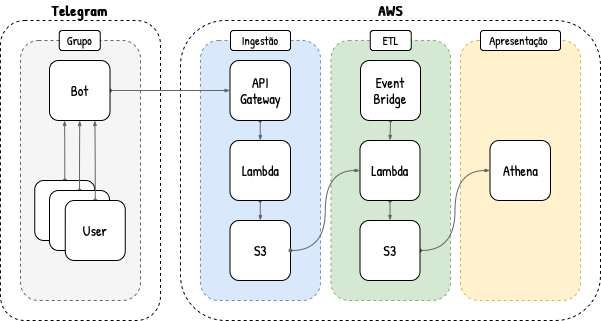



> O Telegram representa a fonte de dados transacionais. Mensagens enviadas por usuários em um grupo são capturadas por um bot e redirecionadas via webhook do backend do aplicativo para um endpoint (endereço web que aceita requisições HTTP) exposto pelo AWS API Gateway. As mensagens trafegam no corpo ou payload da requisição.


**AWS | Ingestão**

_Uma requisição HTTP com o conteúdo da mensagem em seu payload é recebia pelo AWS API Gateway que, por sua vez, as redireciona para o AWS Lambda, servindo assim como seu gatilho. Já o AWS Lambda recebe o payload da requisição em seu parâmetro event, salva o conteúdo em um arquivo no formato JSON (original, mesmo que o payload) e o armazena no AWS S3 particionado por dia._

**AWS | ETL**

_Uma vez ao dia, o AWS Event Bridge aciona o AWS Lambda que processa todas as mensagens do dia anterior (atraso de um dia ou D-1), denormaliza o dado semi-estruturado típico de arquivos no formato JSON, salva o conteúdo processado em um arquivo no formato Apache Parquet e o armazena no AWS S3 particionado por dia._

**AWS | Apresentação**

_Por fim, uma tabela do AWS Athena é apontada para o bucket do AWS S3 que armazena o dado processado: denormalizado, particionado e orientado a coluna. Profissionais de dados podem então executar consultas analíticas (agregações, ordenações, etc.) na tabela utilizando o SQL para a extração de insights._

## **2. Criação do Bot:**

Com a conta criada no Telegram, abra o chat com o **BotFather** e para a criação do BOT:

Digite **\start:**

Digite **\newbot**

Digite o **nome do bot**, e logo após o **nome de usuário (precisa terminar com o sufixo _bot)**

OBS: Será necessário salvar o token de acesso a API HTTP em um **local seguro.**

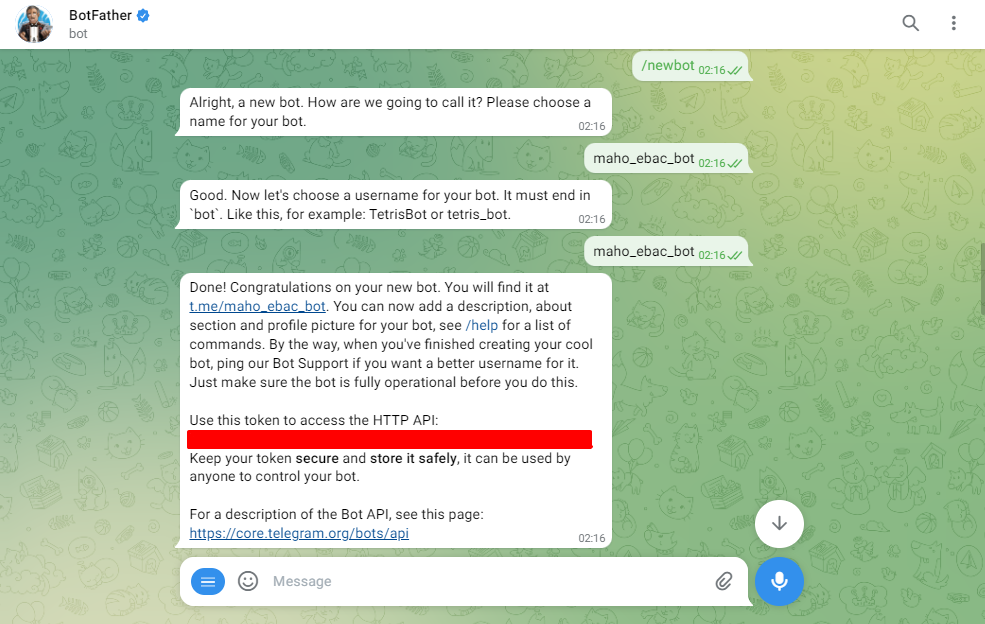

Para ativar o BOT:

Iniciei o chat com o BOT, e digitei **\start.**

**Criação do grupo com o Bot**

Com o grupo criado, adicionei o BOT como administrador para receber todas as mensagens do grupo. Uma outra opção seria desabilitar o seu modo de privacidade.

Abra o chat com o **BotFather:**

- Digite **/mybots;**
- Selecione o bot pelo seu nome de usuário;
- Selecione **Bot Settings;**
- Selecione **Allow Groups?;**
- Selecione **Turn groups off.**

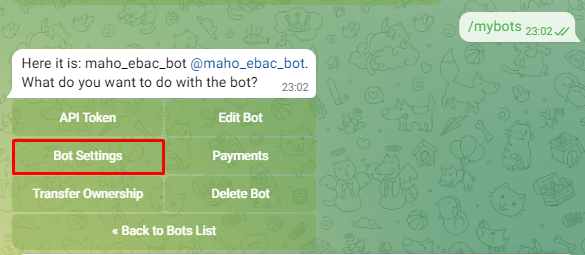
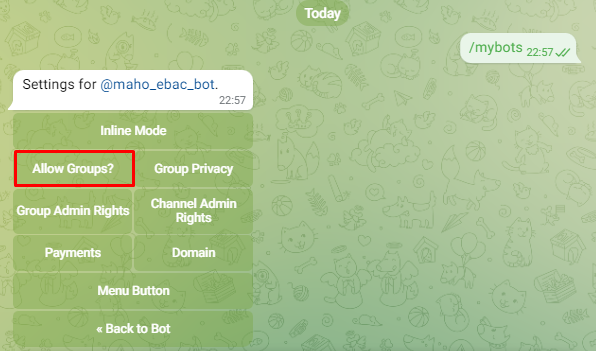
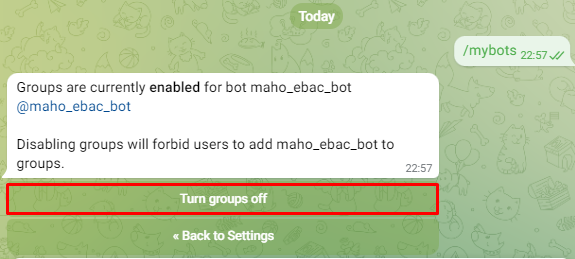

## **3. Bot API:**

As mensagens captadas por um bot podem ser acessadas via API. A única informação necessária é o token de acesso fornecido pelo BotFather na criação do bot. Para isso, vamos utilizar o pacote nativo do Python getpass para ingerir o token, e não deixá-lo exposto no Google colab.

- **Nota:** A documentação completa da API pode ser encontrada neste [link](https://core.telegram.org/bots/api)

In [ ]:
from getpass import getpass

token = getpass()

> A url base é comum a todos os métodos da API.

In [ ]:
import json

import requests

base_url = f'https://api.telegram.org/bot{token}'

- **getMe**



> O método getMe retorna informações sobre o bot.

In [ ]:
response = requests.get(url=f'{base_url}/getMe')
print(f'{base_url}/getMe')

print(json.dumps(json.loads(response.text), indent=2))

- **getUpdates**


> O método getUpdates retorna as mensagens captadas pelo bot.

In [ ]:
response = requests.get(url=f'{base_url}/getUpdates')

print(json.dumps(json.loads(response.text), indent=2))

## **4. Dados**

- Antes de avançar para etapa analítica, vamos trabalhar na manipulação dos dados de mensagens do Telegram.

**Mensagem:**

Uma mensagem recuperada via API é um dado semi-estruturado no formato JSON com algumas chaves mandatórias e diversas chaves opcionais, estas últimas presentes (ou não) dependendo do tipo da mensagem. Por exemplo, mensagens de texto apresentam a chave **text** enquanto mensagens de áudio apresentam a chave **audio**. Neste projeto vamos focar em mensagens do tipo texto, ou seja, vamos ingerir as chaves mandatórias e a chave **text.**

> **Nota:** A lista completa das chaves disponíveis pode ser encontrada na documentação neste [link](https://core.telegram.org/bots/api#message).

In [ ]:
#Exemplo
%%writefile telegram.json
  {
      "update_id": 339399877,
      "message": {
        "message_id": 9,
        "from": {
          "id": 5943360914,
          "is_bot": false,
          "first_name": "Mahogany",
          "last_name": "Moreira",
          "language_code": "pt-br"
        },
        "chat": {
          "id": -10019[censurei essa parte],
          "title": "Projeto final EBAC",
          "type": "supergroup"
        },
        "date": 1684391220,
        "text": "testando  o bot"
      }
  }

- **Descrição:**

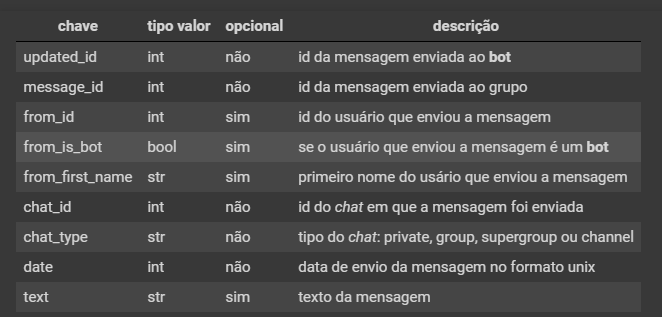

## **5. Ingestão**

A etapa de **ingestão** é responsável, como seu o próprio nome diz, pela ingestão dos dados transacionais em ambientes analíticos. De maneira geral, o dado ingerido é persistido no formato mais próximo do original, ou seja, nenhuma transformação é realizada em seu conteúdo ou estrutura (*schema*). Como exemplo, dados de uma API *web* que segue o formato REST (*representational state transfer*) são entregues, logo, persistidos, no formato JSON.


> **Nota:** Persistir os dados em seu formato original trás muitas vantagens, como a possibilidade de reprocessamento.

Pode ser conduzida de duas formas:

 - **Batch**: blocos de dados são ingeridos em uma frequência bem definida, geralmente na escala de horas ou dias;
 - **Streaming**: dados são ingeridos conforme são produzidos e disponibilizados.

No projeto, as mensagens capturadas pelo *bot* podem ser ingeridas através da API *web* de *bots* do **Telegram**, portanto são fornecidos no formato JSON. Como o **Telegram** retem mensagens por apenas 24h em seus servidores, a ingestão via **streaming** é a mais indicada. Para que seja possível esse tipo de **ingestão** seja possível, vamos utilizar um *webhook* (gancho *web*), ou seja, vamos redirecionar as mensagens automaticamente para outra API *web*.

Sendo assim, precisamos de um serviço da AWS que forneça um API *web* para receber os dados redirecionados, o `AWS API Gateway` (documentação neste [link](https://docs.aws.amazon.com/pt_br/apigateway/latest/developerguide/welcome.html)). Dentre suas diversas funcionalidades, o `AWS API Gateway` permite o redirecionamento do dado recebido para outros serviços da AWS. Logo, vamos conecta-lo ao `AWS Lambda`, que por sua vez, irá armazenar o dado em seu formato original (JSON) em um *bucket* do `AWS S3`.

> **Nota:** Sistemas que reagem a eventos são conhecidos como *event-driven*.

Portanto:

- Criei um *bucket* no `AWS S3`;
- Criei uma função no `AWS Lambda`;
- Criei uma API *web* no `AWS API Gateway`;
- Configurei o *webhook* da API de *bots* do **Telegram**. 

### **AWS S3**

Na etapa de **ingestão**, o `AWS S3` tem a função de passivamente armazenar as mensagens captadas pelo *bot* do **Telegram** no seu formato original: JSON. Para tanto, basta a criação de um *bucket*. Como padrão, vamos adicionar o sufixo `-raw` ao seu nome (vamos seguir esse padrão para todos os serviços desta camada).

> **Nota**: um `data lake` é o nome dado a um repositório de um grande volume dados. É organizado em zonas que armazenam replicadas dos dados em diferentes níveis de processamento. A nomenclatura das zonas varia, contudo, as mais comuns são: **raw** e **enriched** ou **bronze**, **silver** e **gold**.

Criei um bucket no AWS S3 com o nome **"projeto-ebac-datalake-raw"**.

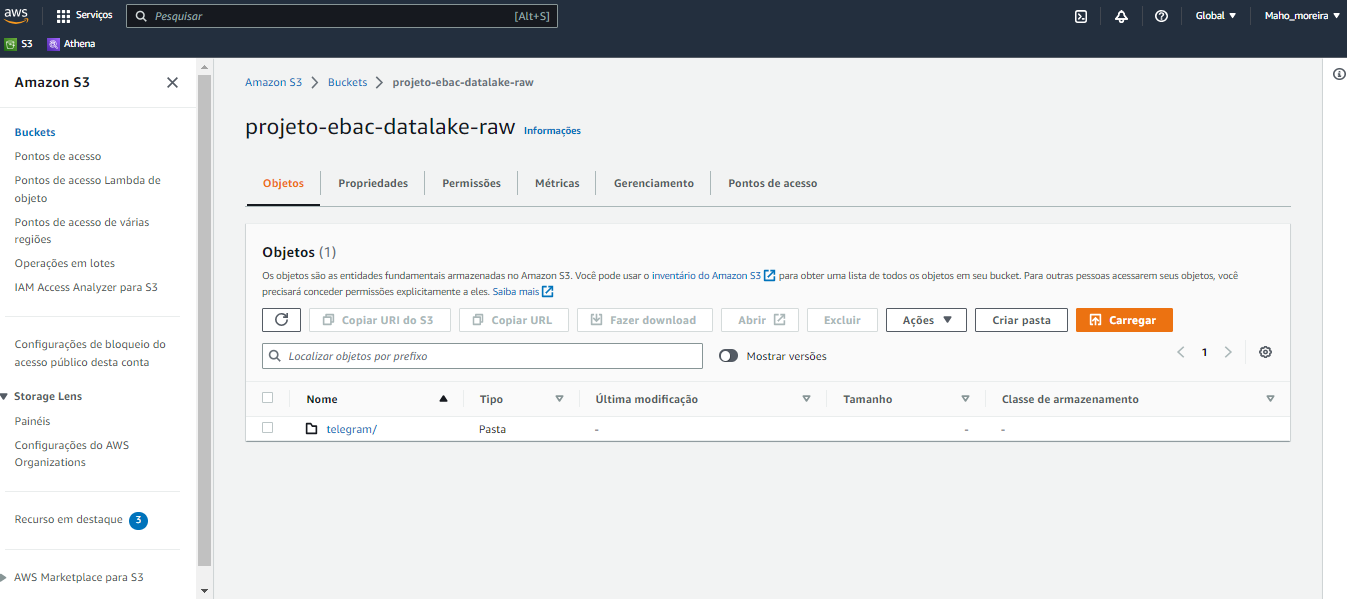

### **AWS Lambda**

Na etapa de **ingestão**, o `AWS Lambda` tem a função de ativamente persistir as mensagens captadas pelo *bot* do **Telegram** em um *bucket* do `AWS S3`. Para tanto vamos criar uma função que opera da seguinte forma:

- Recebe a mensagem no parâmetro `event`;
- Verifica se a mensagem tem origem no grupo do **Telegram** correto;
- Persiste a mensagem no formato JSON no *bucket* do `AWS S3`;
- Retorna uma mensagem de sucesso (código de retorno HTTP igual a 200) a API de *bots* do **Telegram**.

> **Nota**: No **Telegram**, restringimos a opção de adicionar o *bot* a grupos, contudo, ainda é possível iniciar uma conversa em um `chat privado`.

Criei a função Lambda com o mesmo nome do bucket no S3 **"projeto-ebac-datalake-raw"**.

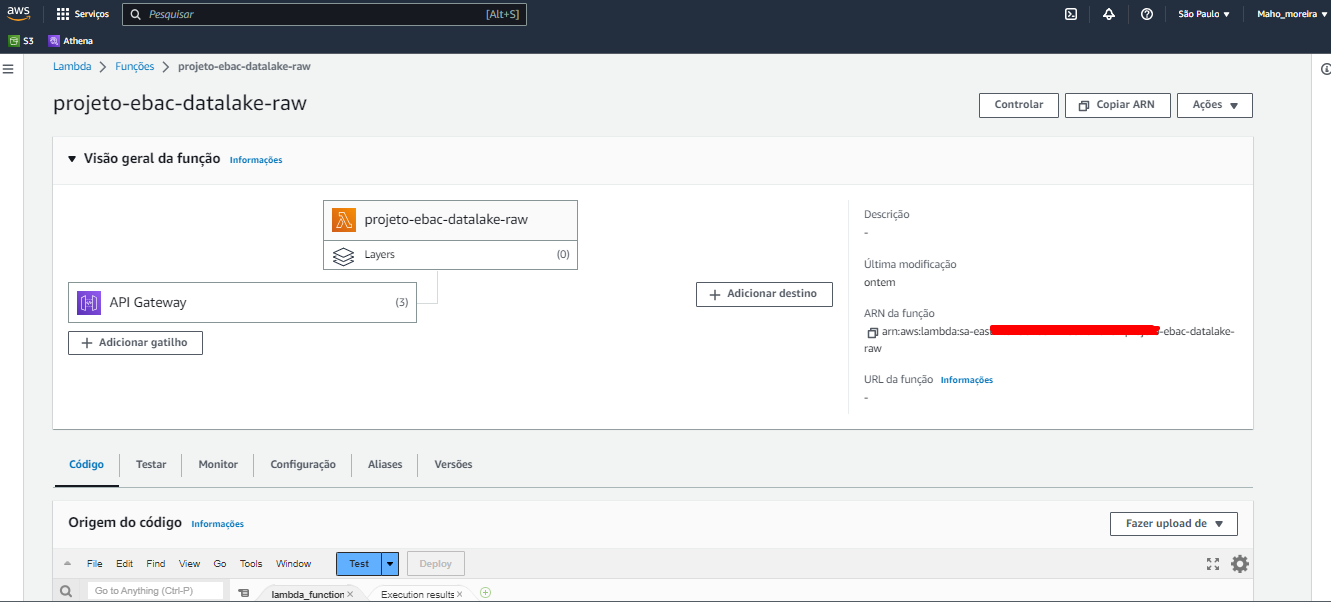

Inseri o seguinte **código na função:**

In [ ]:
#pacotes e bibliotecas

import os
import json
import logging
from datetime import datetime, timezone, timedelta


import boto3


def lambda_handler(event: dict, context: dict) -> dict:
    '''
    Recebe uma mensagem do Telegram via AWS API Gateway, verifica no
    seu conteúdo se foi produzida em um determinado grupo e a escreve,
    em seu formato original JSON, em um bucket do AWS S3.
    '''

     #variáveis de ambiente

    BUCKET = os.environ['AWS_S3_BUCKET']
    TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

     #variáveis lógicas

    tzinfo = timezone(offset=timedelta(hours=-3))
    date = datetime.now(tzinfo).strftime('%Y-%m-%d')
    timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

    filename = f'{timestamp}.json'

    # código principal

    client = boto3.client('s3')

    try:
        messages = json.loads(event["body"])  # A mensagem é uma lista de objetos
        for message in messages:
            chat_id = message["message"]["chat"]["id"]

            if chat_id == TELEGRAM_CHAT_ID:
                with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
                    json.dump(message, fp)

                client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

    except Exception as exc:
        logging.error(msg=exc)
        return dict(statusCode="500")

    else:
        return dict(statusCode="200")

> **Nota:** Para que a função funcione corretamente, algumas configurações precisam ser realizadas.

 - **Variáveis de ambiente**

Note que o código exige a configuração de duas variáveis de ambiente: `AWS_S3_BUCKET` com o nome do *bucket* do `AWS S3` e `TELEGRAM_CHAT_ID` com o id do *chat* do grupo do **Telegram**. Para adicionar variáveis de ambiente em uma função do `AWS Lambda`, basta acessar configurações -> `variáveis de ambiente no console da função.`


> **Nota**: Variáveis de ambiente são excelentes formas de armazenar informações sensíveis.

Preenchi da seguinte forma as **variáveis de ambiente na função Lambda criada na AWS:**

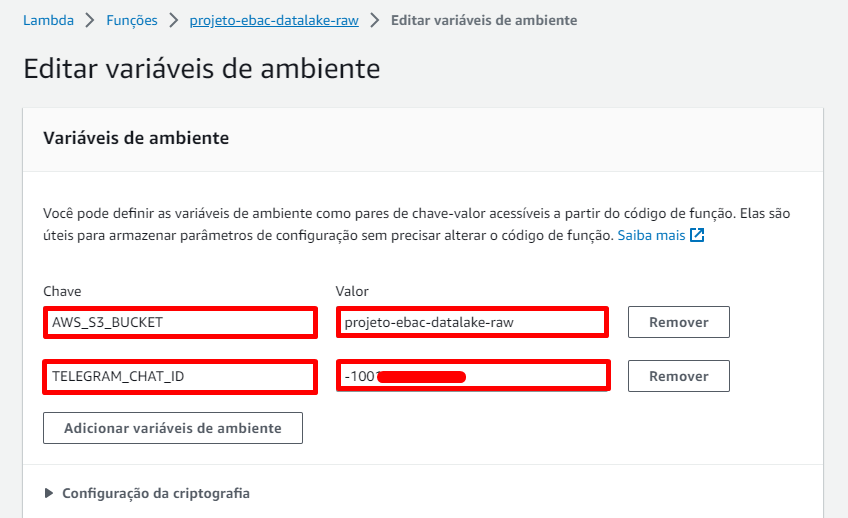

 - **Permissão**
 
 Por fim, precisamos adicionar a permissão de escrita no *bucket* do `AWS S3` para a função do `AWS Lambda` no `AWS IAM`.

Anexei a política de **"AmazonS3FullAccess"** que garante o acesso total a qualquer bucket no meu AWS S3.

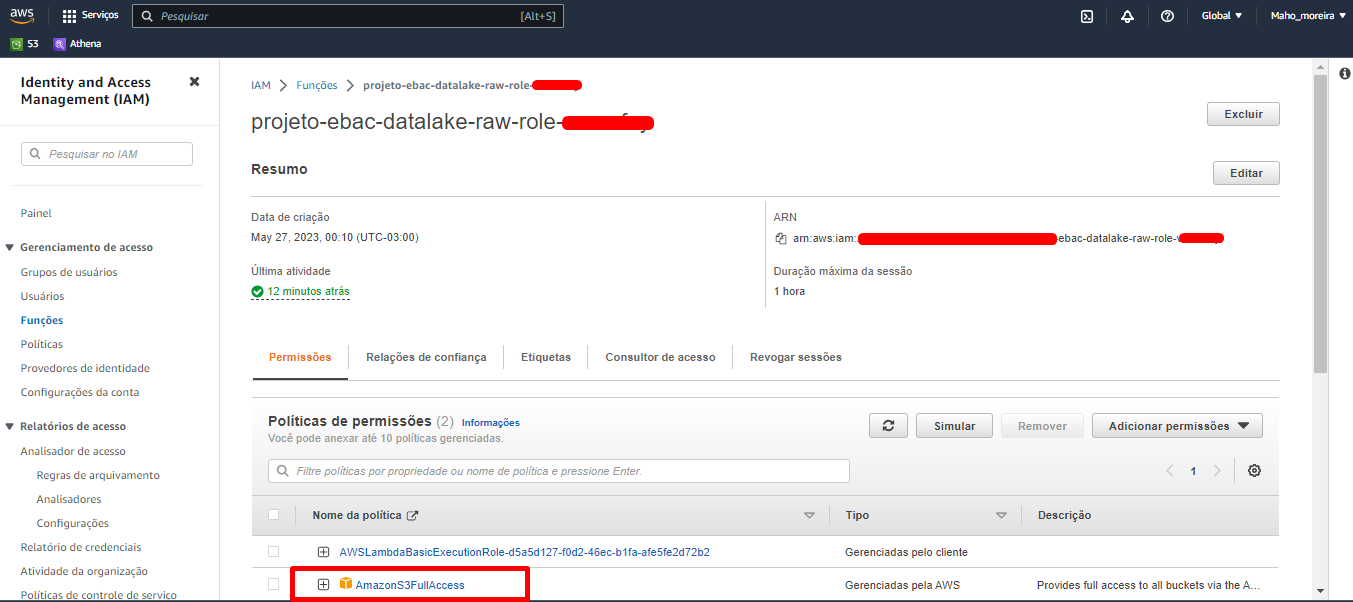


> **Nota:** Vale ressaltar que o recomendado é seguir com permissões específicas para cada usuário, assim evitando problemas em relação a segurança de seus dados. A permissão escolhida neste projeto ocorreu somente para fins didáticos.

### **AWS API Gateway**



Na etapa de **ingestão**, o `AWS API Gateway` tem a função de receber as mensagens captadas pelo *bot* do **Telegram**, enviadas via *webhook*, e iniciar uma função do `AWS Lambda`, passando o conteúdo da mensagem no seu parâmetro *event*. Para tanto vamos criar uma API e configurá-la como gatilho da função do `AWS Lambda`:

- Acessei o serviço e selecionei: *Create API* -> *REST API*;
- Inseri um nome, como padrão, um que terminou com o sufixo `-api`;
- Selecionei: *Actions* -> *Create Method* -> *POST*;
- Na tela de *setup*: 
- Selecionei *Integration type* igual a *Lambda Function*;
- Habilitei o *Use Lambda Proxy integration*;
- Busquei pelo nome a função do `AWS Lambda`.


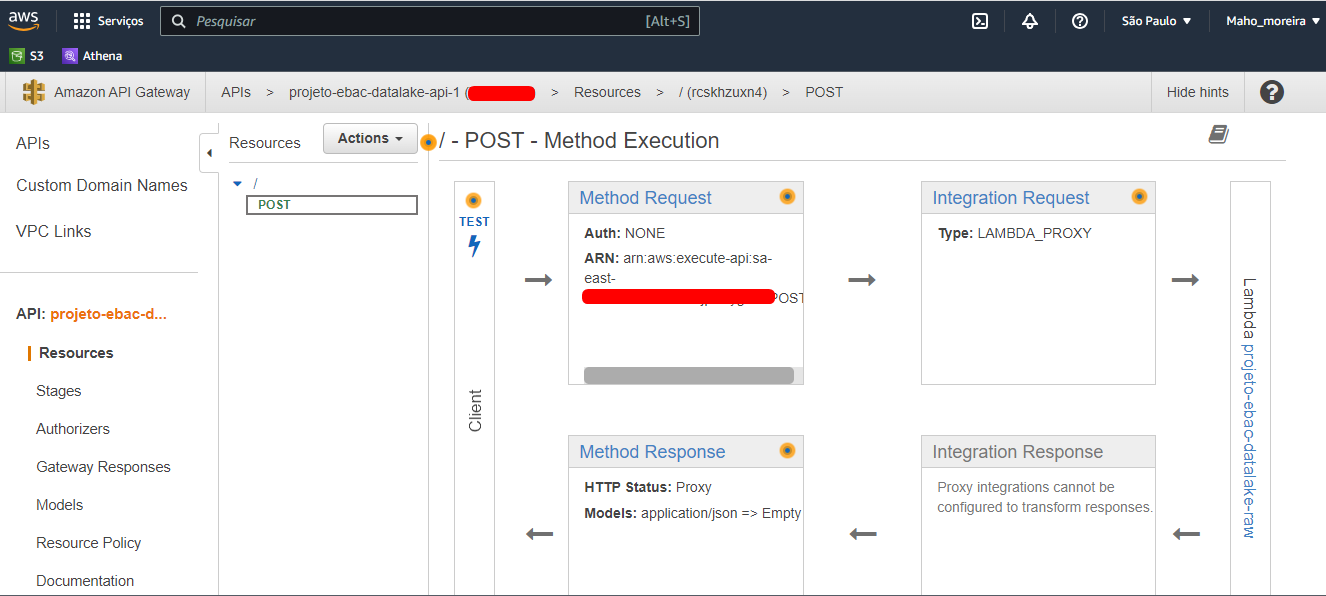

Podemos testar a integração com o `AWS Lambda` através da ferramenta de testes do serviço. Por fim, vamos fazer a implantação da API e obter o seu endereço *web*.

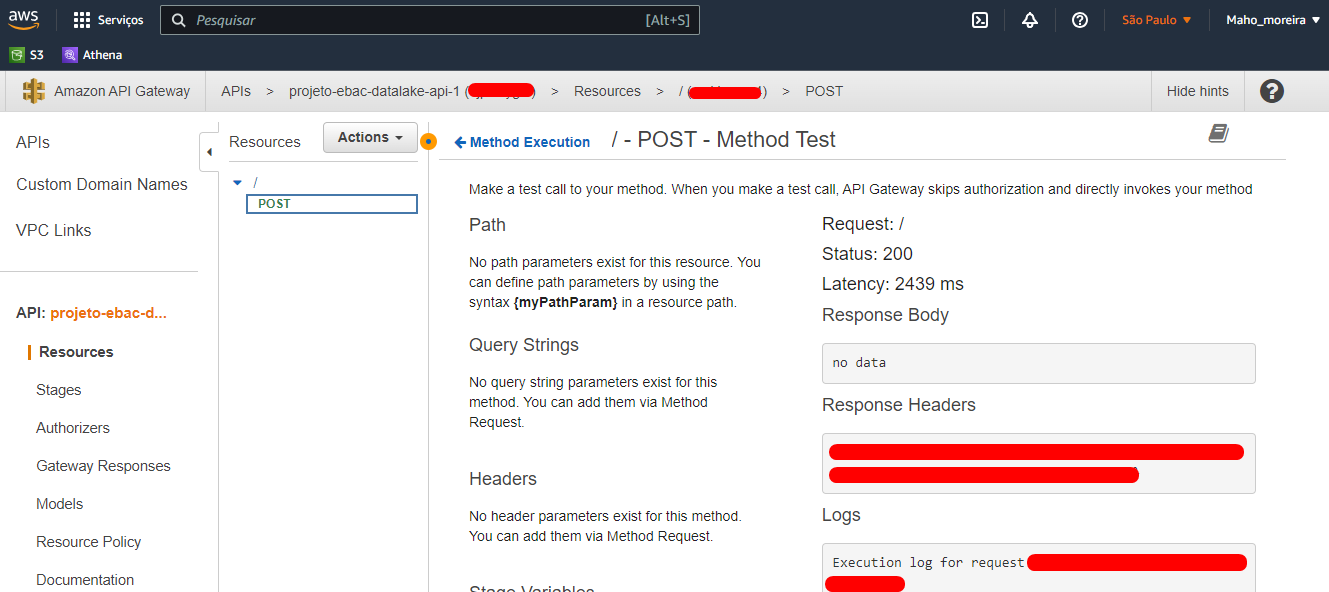

> **Nota:** Após o deploy da API e com o seu endereço web em mãos, configurei o webhook para redirecionar as mensagens para a `url` do AWS API Gateway.


Inserindo **url** gerada na variável **aws_api_gateway_url**.


In [ ]:
aws_api_gateway_url = getpass()

### **Telegram**

Vamos configurar o *webhook* para redirecionar as mensagens para a `url` do `AWS API Gateway`.



 - **setWebhook**
 
 O método `setWebhook` configura o redirecionamento das mensagens captadas pelo *bot* para o endereço *web* do paramametro `url`.

> **Nota**: os métodos `getUpdates` e `setWebhook` são mutualmente exclusivos, ou seja, enquanto o *webhook* estiver ativo, o método `getUpdates` não funcionará. Para desativar o *webhook*, basta utilizar o método `deleteWebhook`.

In [ ]:
response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

 - **getWebhookInfo**
 
 O método `getWebhookInfo` retorna as informações sobre o *webhook* configurado.

In [ ]:
response = requests.get(url=f'{base_url}/getWebhookInfo')

print(json.dumps(json.loads(response.text), indent=2))

## **6. ETL (Extração, Transformação e Carregamento)**

A etapa de extração, transformação e carregamento (ETL) em um projeto de análise de dados é o processo fundamental de coletar dados de várias fontes, transformá-los em um formato adequado e carregá-los em um local de destino, como um data warehouse ou um banco de dados.

Durante a extração, os dados são obtidos de diferentes fontes, como bancos de dados, arquivos ou APIs. Em seguida, ocorre a transformação, que envolve limpeza, filtragem, agregação e manipulação dos dados para torná-los consistentes e úteis para análise. Por fim, os dados transformados são carregados em um local adequado, onde podem ser acessados para análise e geração de insights.

O processo ETL é crucial para garantir que os dados estejam prontos para análise, fornecendo uma base confiável e consistente para as atividades de análise de dados.

No projeto, as mensagens de um único dia, persistidas na camada cru, serão compactas em um único arquivo, orientado a coluna e comprimido, que será persistido em uma camada enriquecida. Além disso, durante este processo, o dado também passará por etapas de **data wrangling**.

> Para isso, vamos utilizar uma função do `AWS Lambda` como motor de processamento e um *bucket* do `AWS S3` como camada enriquecida para a persistência do dado processado. Para garantir a recorrência, vamos configurar uma regra do `AWS Event Bridge` como gatilho diáro da função.

Criei o bucket **"projeto-ebac-datalake-enriched"** para receber o arquivo processado no formato **Apache Parquet:**

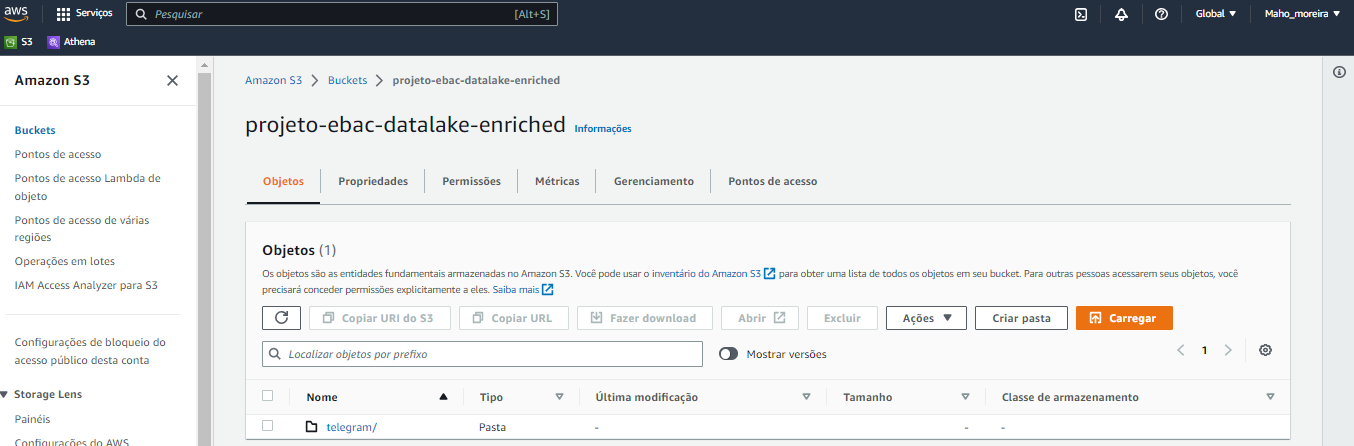

> **Nota:** Uma vez ao dia, o AWS Event Brigde aciona o AWS Lambda que, por sua vez, processa todas as mensagens geradas no dia anterior (D-1), denormaliza o dado semi-estruturado típico de arquivos JSON, salva o conteúdo processado em um arquivo no formato Apache Parquet, e o armazena no AWS S3 particionado por dia.

**AWS Lambda:**

Aqui o AWS Lambda tem a função de ativamente processar as mensagens captadas pelo bot do Telegram, persistidas na camada cru no bucket do AWS S3, e persisti-las na camada enriquecida, também em um bucket do AWS S3.

**A função criada terá como objetivo:**

- Listar todos os arquivos JSON de uma única participação da camada crua de um bucket do AWS S3;
- Para cada arquivo listado: Faz o download do arquivo e carrega o conteúdo da mensagem;
- Executa uma função de data wrangling;
- Cria uma tabela do PyArrow e a concatena com as demais;
- Persiste a tabela no formato Parquet na camada enriquecida em um bucket do AWS S3.

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagens, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único 
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # variáveis de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # variáveis lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None
          
      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True
  
  except Exception as exc:
      logging.error(msg=exc)
      return False

- Também o código do Data Wrangling:

In [ ]:
def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

Criei a função Lambda na AWS com o nome **"projeto-ebac-datalake-enriched"**.

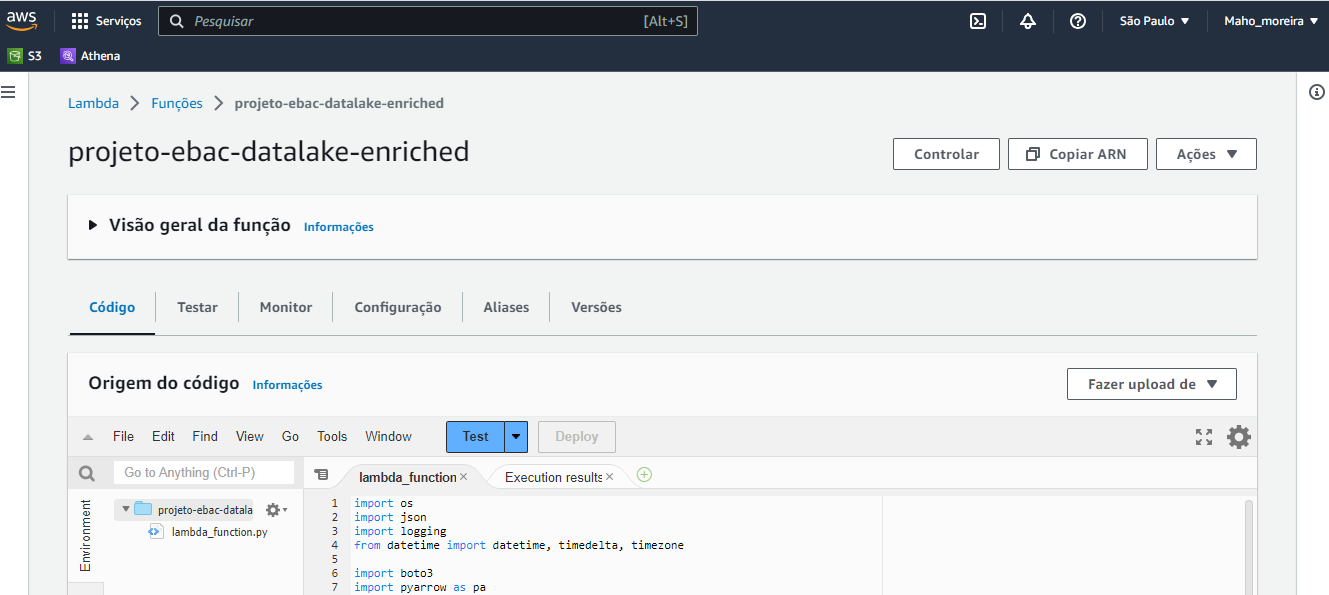

> **Nota:** As Variáveis de ambiente e Permissão foram configuradas da mesma forma como foi mostrado na função anterior **"projeto-ebac-datalake-raw".**

### **Camadas**

Por fim, note que o código da função utiliza o pacote Python PyArrow. Contudo, o ambiente padrão do `AWS Lambda` possui poucos pacotes externos instalados, como o pacote Python boto3, logo o PyArrow não será encontrado e a execução da função falhará. Existem algumas formas de adicionar pacotes externos no ambiente de execução do AWS Lambda, um deles é a criação de camadas ou *layers*, onde podemos fazer o *upload* dos pacotes Python direto na plataforma ou através de um *bucket* do `AWS S3`. Vamos então seguir com a última opção, onde:

 - Crei um *bucket* no `AWS S3`;
 - Fiz o *upload* do código do pacote Python do PyArrow (*download* neste [link](https://github.com/awslabs/aws-data-wrangler/releases));
 - Criei um *layer* e conectei na função.

Criei o bucket **"projeto-ebac-lambda-layer"** e carreguei o arquivo nele.

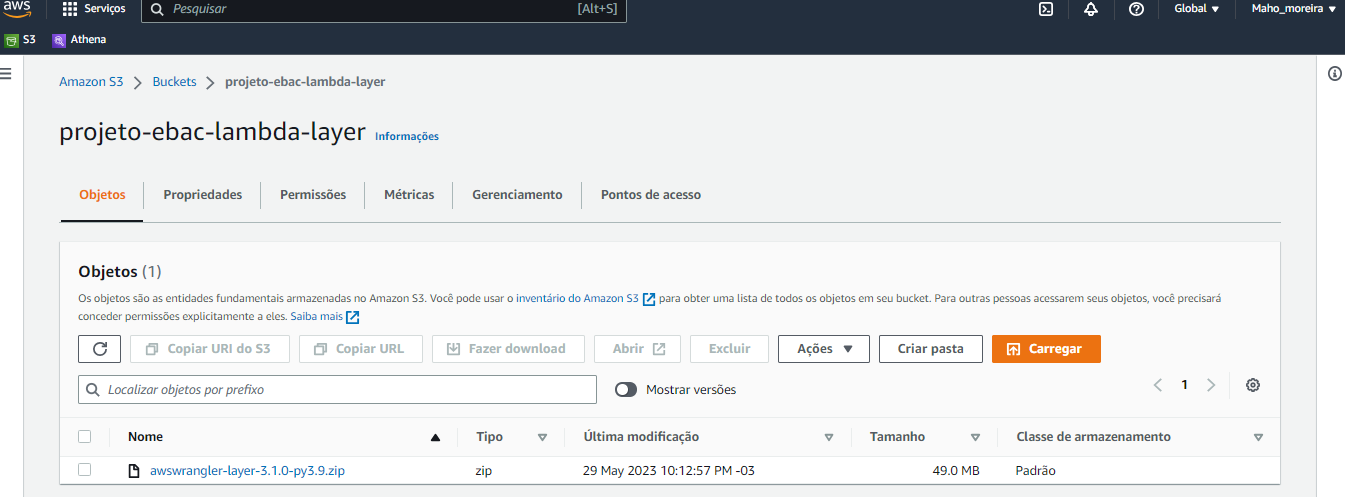

**Versão da camada PyArrow criada.**

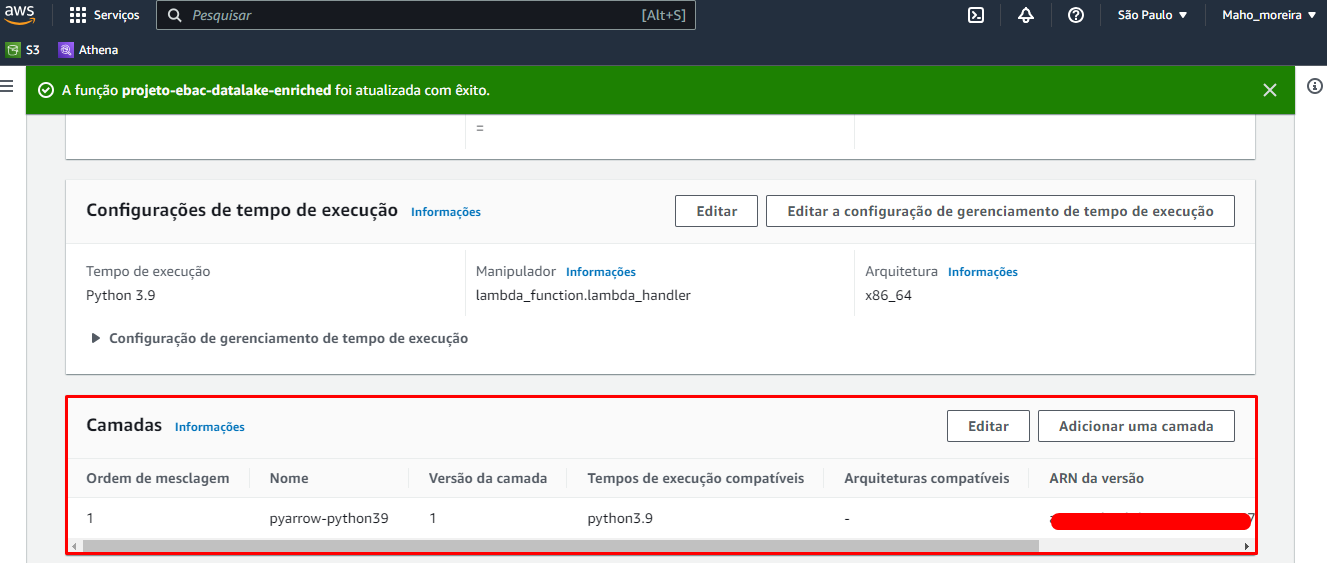


Arquivos carregados no bucket do S3 (enriched) no **formato Parquet:**

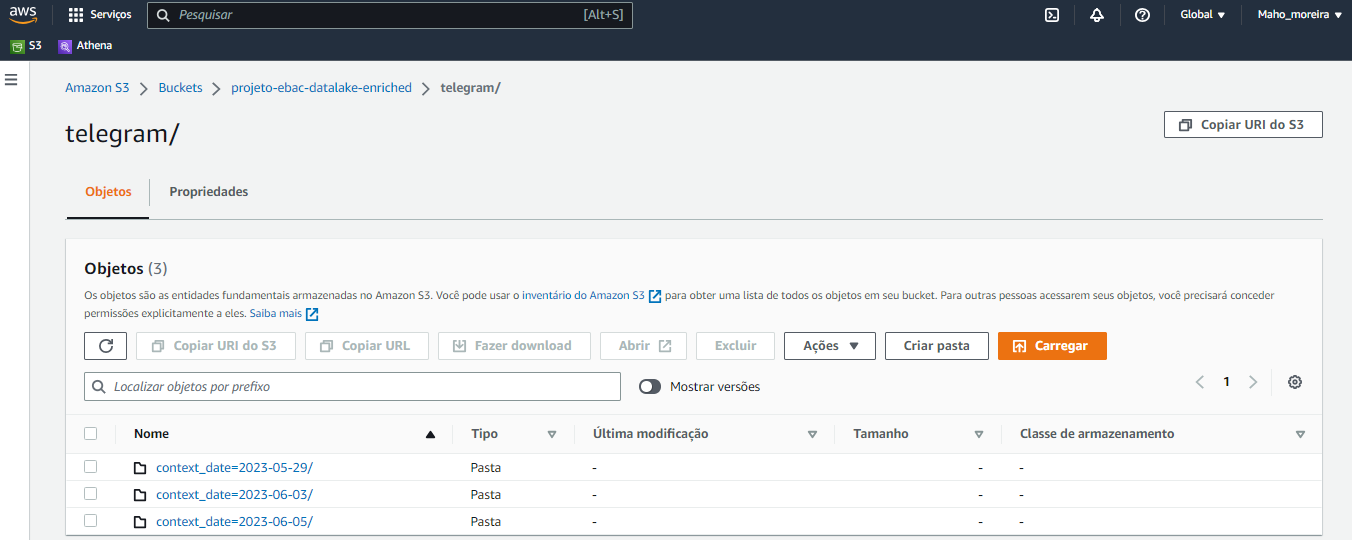
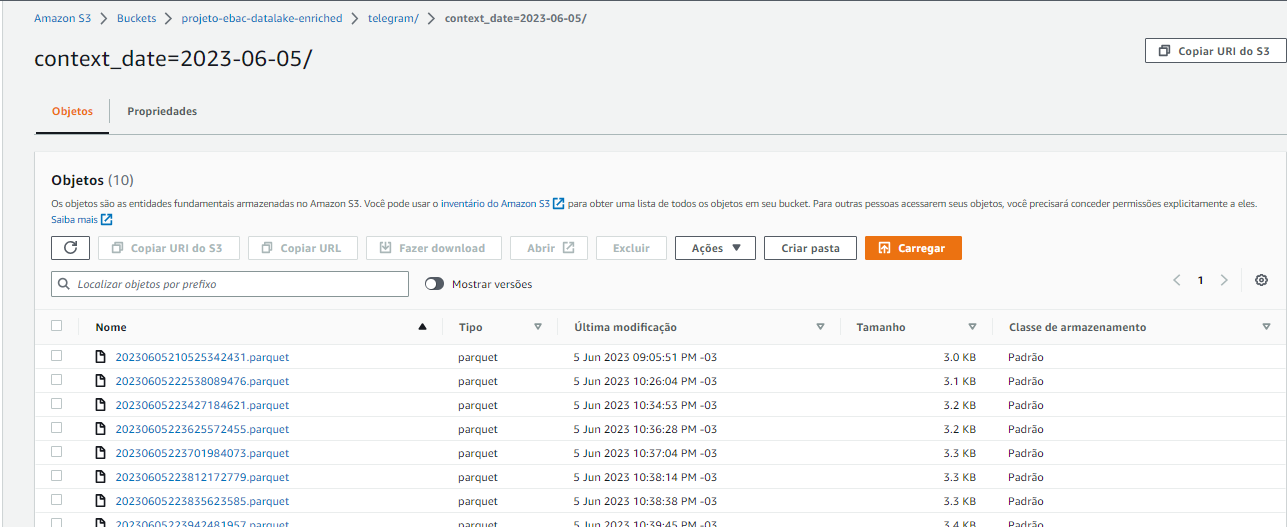


> **Nota:** Printei somente o dia 05/06 para exemplo.

### **AWS Event Bridge** 

Na etapa de **ETL**, o `AWS Event Bridge` tem a função de ativar diariamente a função de **ETL** do `AWS Lambda`, funcionando assim como um *scheduler*.



> **Nota**: Atente-se ao fato de que a função processa as mensagens do dia anterior (D-1).

**Regra criada com sucesso.**

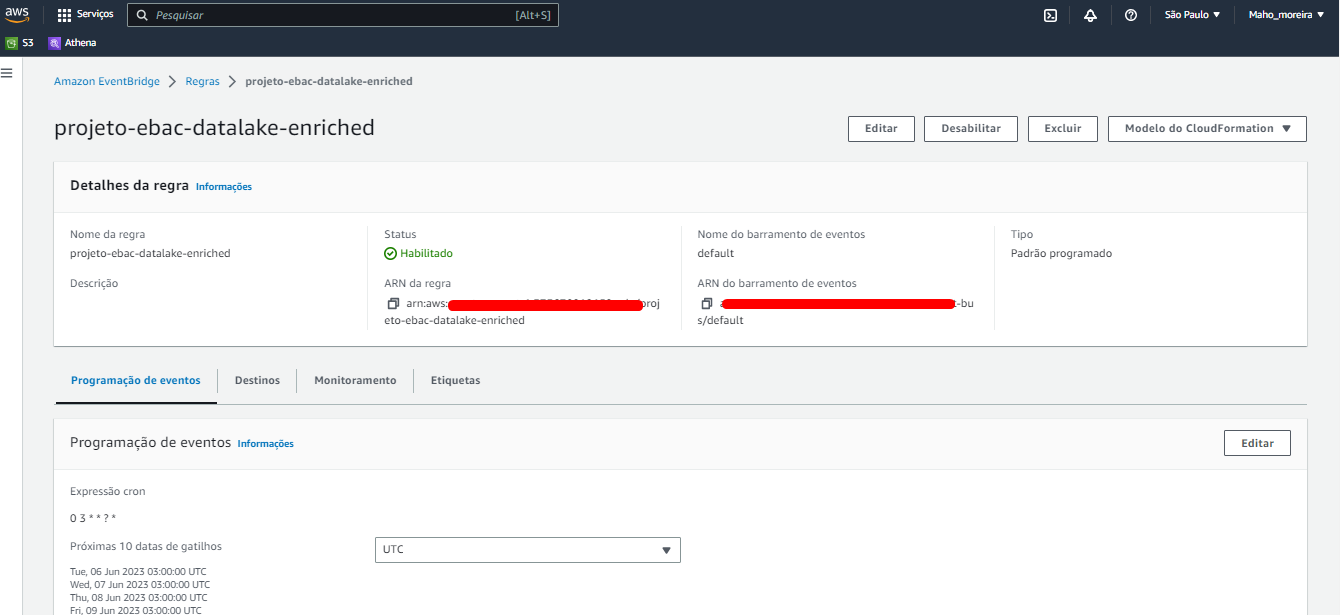

## **7. Apresentação**

A etapa de **apresentação** é reponsável por entregar o dado para os usuários (analistas, cientistas, etc.) e sistemas (dashboards, motores de consultas, etc.), idealmente através de uma interface de fácil uso, como o SQL, logo, essa é a única etapa que a maioria dos usuários terá acesso. Além disso, é importante que as ferramentas da etapa entregem dados armazenados em camadas refinadas, pois assim as consultas são mais baratas e o dados mais consistentes.

### **AWS Athena**


Na etapa de **apresentação**, o `AWS Athena` tem função de entregar os dados através de uma interface SQL para os usuários do sistema analítico. Para criar a interface, basta criar uma tabela externa sobre o dado armazenado na camada mais refinada da arquitetura, a camada enriquecida.

Criando a tabela **"telegram"** no **AWS Athena**

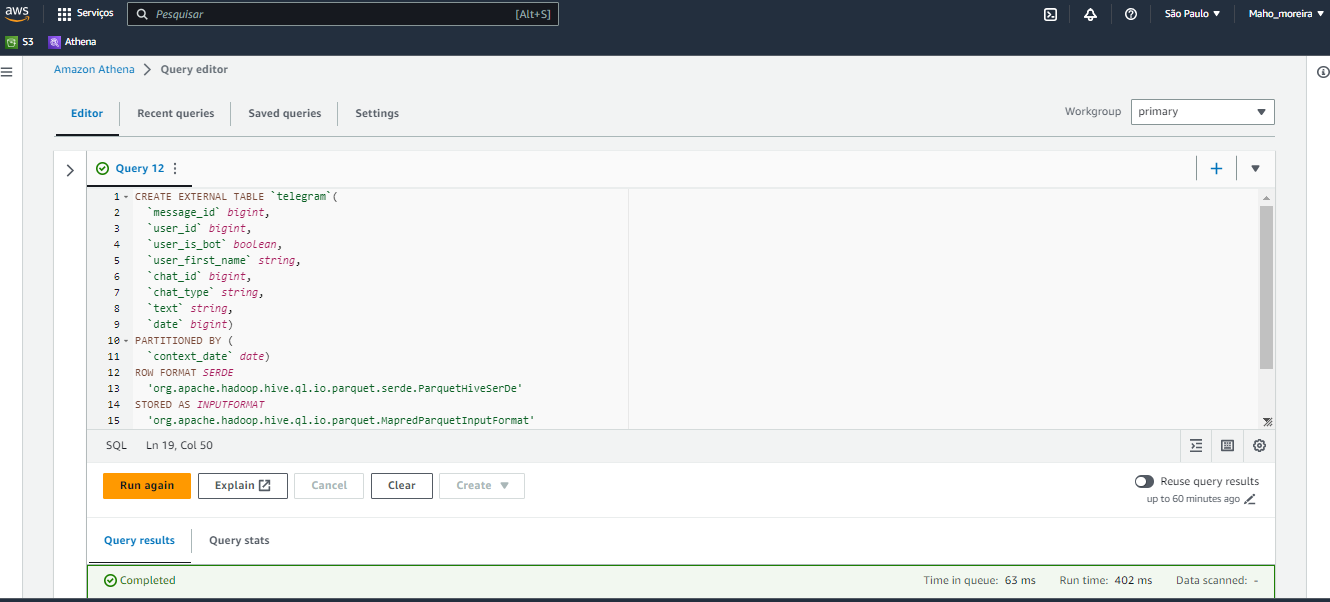


**Query:**

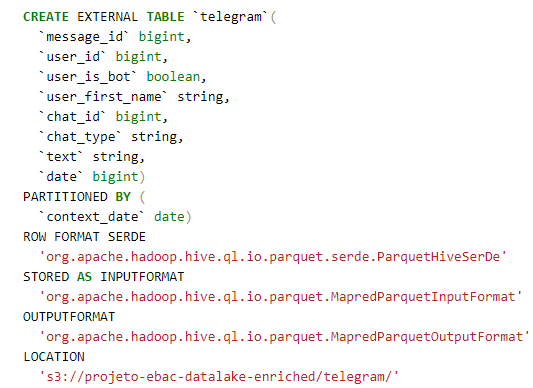

Carregando partições na tabela **"telegram".**

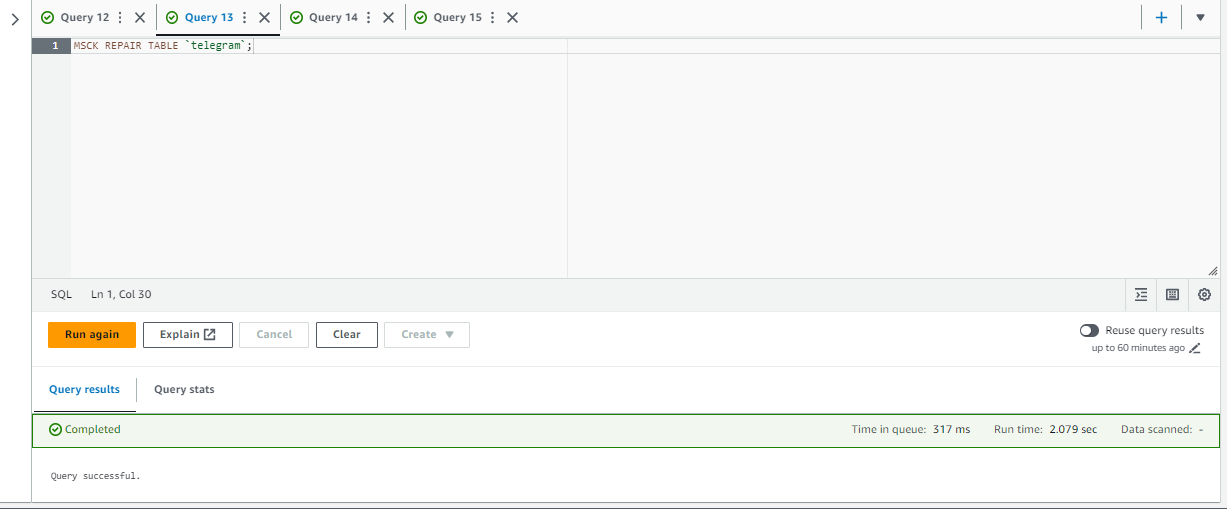

**Query:**
> `MSCK REPAIR TABLE 'telegram';`

**Obs:** Na query acima ao redor de telegram, usamos aspas duplas invertidas.

> **Nota:** Toda vez que uma nova partição é adicionada ao repositório de dados, é necessário informar ao AWS Athena para que ela esteja disponível via SQL.

### **Analytics** 

Com os dados disponíveis, os usuários podem executar as mais variadas consultas analíticas e extrais insights.

Seguem alguns exemplos didáticos, pois nesse caso os conteúdos das mensagens não serão analisados a fundo:

- **Visualizando as 10 primeiras linhas da tabela:**

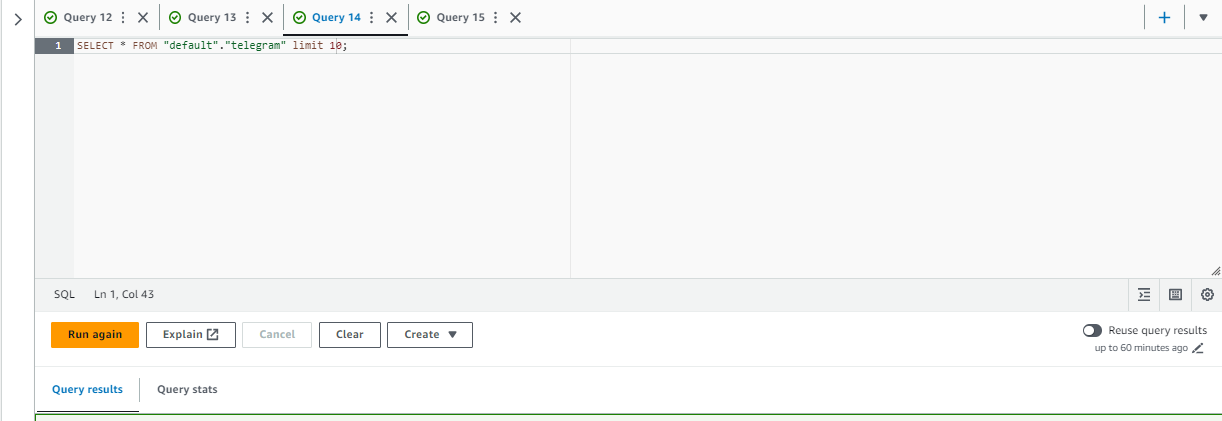
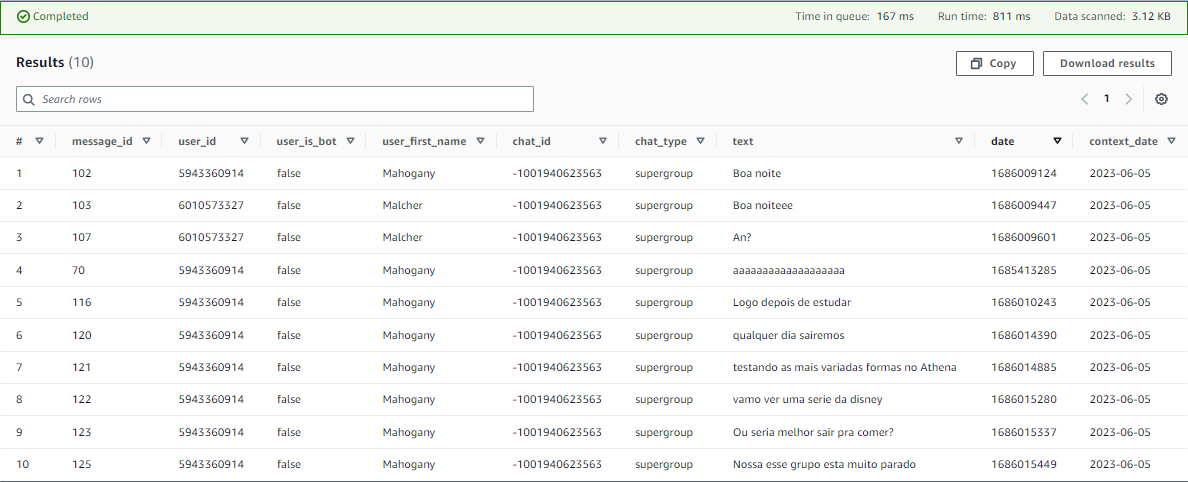

**Query:**
> `SELECT * FROM "default"."telegram" limit 10;`

- **Visualizando a primeira mensagem enviada no dia 29/05:**

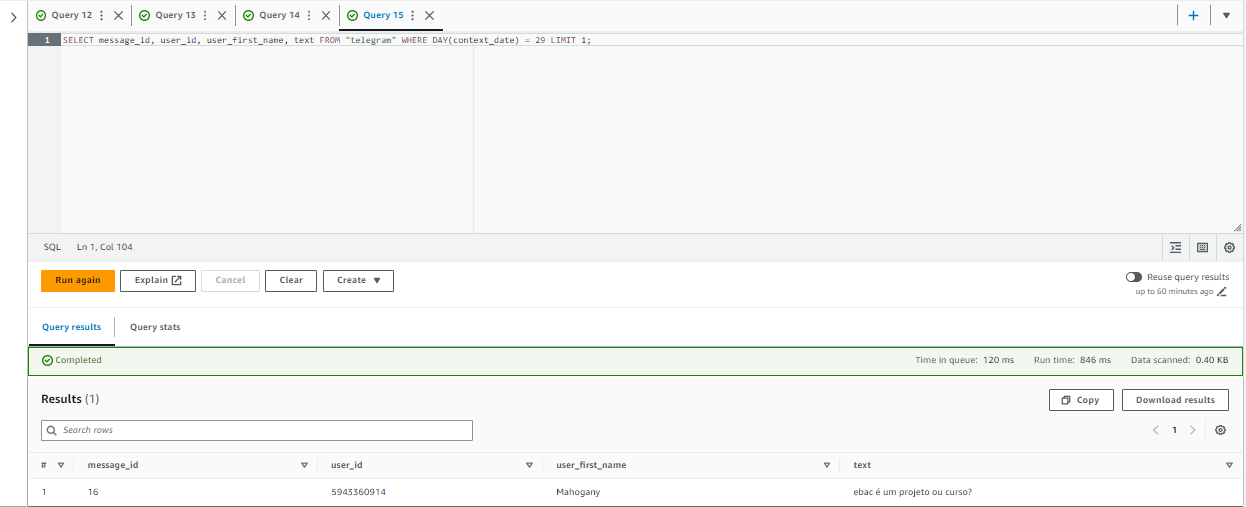

**Query**:
> `SELECT message_id, user_id, user_first_name, text FROM "telegram" WHERE DAY(context_date) = 29 LIMIT 1;`

- **Visualizando a quantidade de mensagens por dia:**

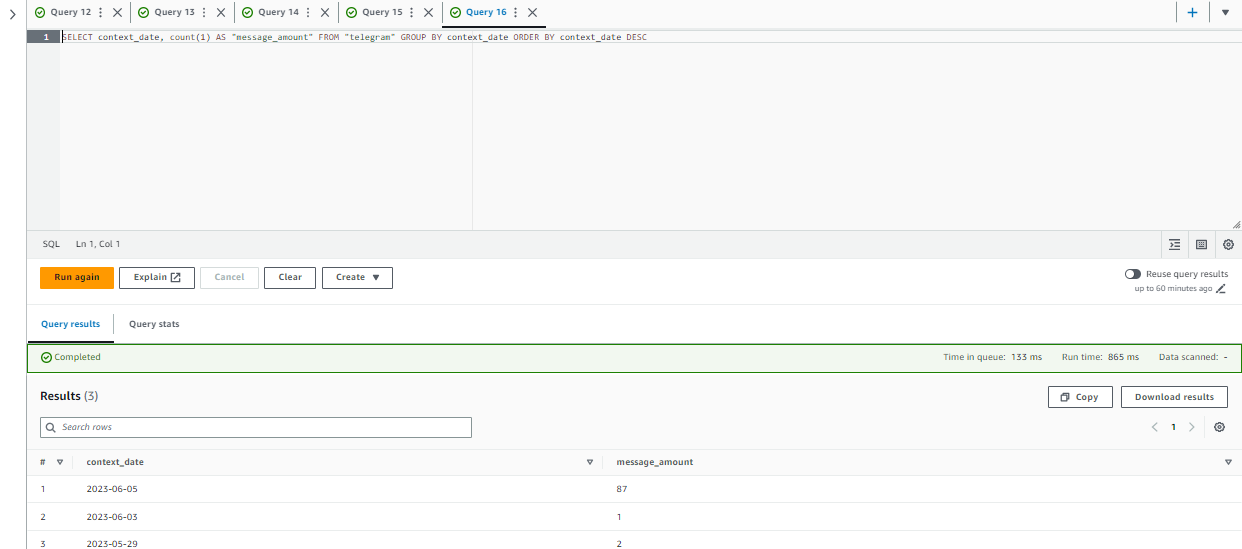

**Query:**
> `SELECT context_date, count(1) AS "message_amount" FROM "telegram" GROUP BY context_date ORDER BY context_date DESC`


- **Média do tamanho das mensagens por usuário por dia:**

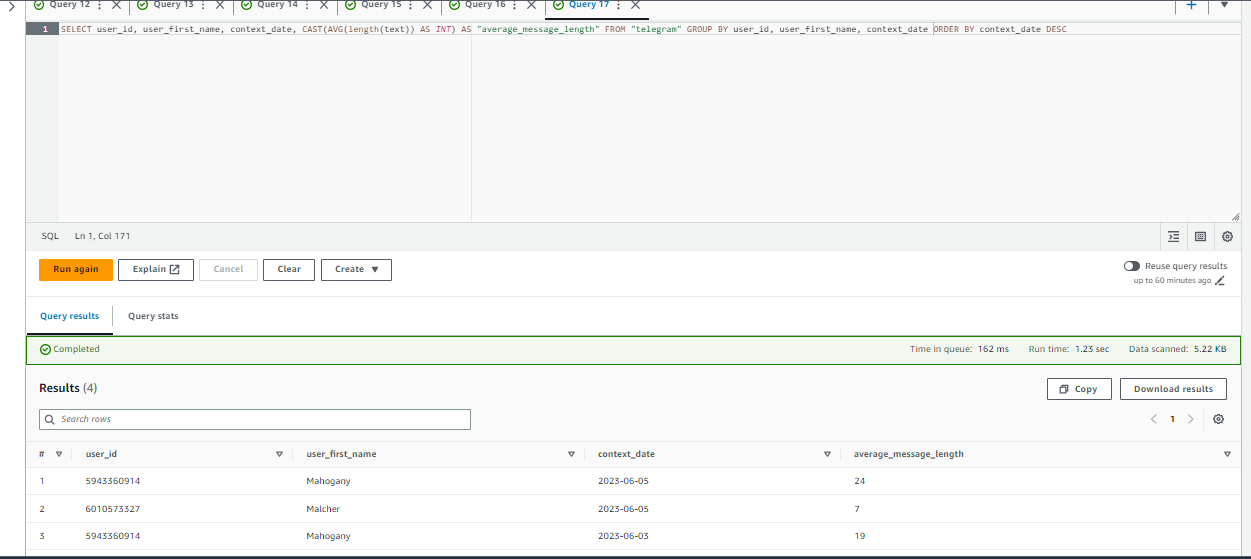

**Query:**
> `SELECT user_id, user_first_name, context_date, CAST(AVG(length(text)) AS INT) AS "average_message_length" FROM "telegram" GROUP BY user_id, user_first_name, context_date ORDER BY context_date DESC`

## **8. Conclusão**

A combinação de `chatbots` e `análise de dados` oferece benefícios valiosos para empresas.
Os chatbots facilitam a interação com os clientes, enquanto a análise dos dados obtidos proporciona insights importantes para tomadas de decisão estratégicas.
Essa combinação melhora a experiência do cliente, otimiza processos internos e impulsiona o crescimento empresarial em todos os setores.
Portanto, a criação de uma `Pipeline de Dados junto ao Bot do Telegram` é uma ferramenta muito rica e cheia de oportunidades.